In [220]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor
from fancyimpute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [221]:
data = pd.read_csv('payment-practices.csv')
data.head()

,Report Id,Start date,End date,Filing date,Company,Company number,Payments made in the reporting period,Average time to pay,% Invoices paid within 30 days,% Invoices paid between 31 and 60 days,...,Longest standard payment period,Maximum contractual payment period,Payment terms have changed,Suppliers notified of changes,Participates in payment codes,E-Invoicing offered,Supply-chain financing offered,Policy covers charges for remaining on supplier list,Charges have been made for remaining on supplier list,URL
0,2,29-04-2017,28-10-2017,07-11-2017,MEDTRONIC LIMITED,1070807,NaN,25.0,77.0,20.0,...,60.0,60.0,False,NaN,False,True,False,False,False,https://check-payment-practices.service.gov.uk...
1,3,01-05-2017,31-10-2017,08-11-2017,SEBDEN STEEL SERVICE CENTRES LIMITED,2553464,NaN,69.0,7.0,28.0,...,NaN,75.0,False,NaN,False,False,False,False,False,https://check-payment-practices.service.gov.uk...
2,4,15-04-2017,14-10-2017,08-11-2017,GREENERGY FLEXIGRID LIMITED,7581532,NaN,21.0,89.0,9.0,...,30.0,30.0,False,NaN,False,False,False,True,True,https://check-payment-practices.service.gov.uk...
3,5,15-04-2017,14-10-2017,08-11-2017,GREENERGY FUELS LIMITED,4058825,NaN,14.0,90.0,8.0,...,30.0,30.0,False,NaN,False,False,False,True,True,https://check-payment-practices.service.gov.uk...
4,6,15-04-2017,14-10-2017,08-11-2017,GREENERGY INTERNATIONAL LIMITED,2809935,NaN,15.0,96.0,2.0,...,30.0,30.0,False,NaN,False,False,False,True,False,https://check-payment-practices.service.gov.uk...


In [222]:
# Drop columns that are not useful for the model
columns_to_drop = ['Report Id','Start date', 'End date', 'Filing date', 'Company', 'Company number','URL']
data = data.drop(columns=columns_to_drop)

In [223]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77681 entries, 0 to 77680
Data columns (total 16 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Payments made in the reporting period                  63008 non-null  object 
 1   Average time to pay                                    70822 non-null  float64
 2   % Invoices paid within 30 days                         70822 non-null  float64
 3   % Invoices paid between 31 and 60 days                 70822 non-null  float64
 4   % Invoices paid later than 60 days                     70822 non-null  float64
 5   % Invoices not paid within agreed terms                70973 non-null  float64
 6   Shortest (or only) standard payment period             70973 non-null  float64
 7   Longest standard payment period                        47119 non-null  float64
 8   Maximum contractual payment period            

In [224]:
data.describe()

,Average time to pay,% Invoices paid within 30 days,% Invoices paid between 31 and 60 days,% Invoices paid later than 60 days,% Invoices not paid within agreed terms,Shortest (or only) standard payment period,Longest standard payment period,Maximum contractual payment period
count,70822.000000,70822.000000,70822.000000,70822.000000,70973.000000,70973.000000,47119.000000,70973.000000
mean,36.681300,55.978029,30.119553,13.896134,27.819875,20.522241,70.820073,73.439266
std,23.010175,28.461688,20.590250,16.762054,23.697790,21.603915,46.305430,86.101648
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,24.000000,32.000000,13.000000,3.000000,9.000000,1.000000,60.000000,45.000000
50%,34.000000,58.000000,28.000000,7.000000,22.000000,14.000000,60.000000,60.000000
75%,46.000000,81.000000,45.000000,18.000000,41.000000,30.000000,90.000000,90.000000
max,1120.000000,100.000000,100.000000,100.000000,100.000000,1000.000000,1264.000000,5475.000000


In [225]:
# Missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,14673,18.888789
Average time to pay,6859,8.829701
% Invoices paid within 30 days,6859,8.829701
% Invoices paid between 31 and 60 days,6859,8.829701
% Invoices paid later than 60 days,6859,8.829701
% Invoices not paid within agreed terms,6708,8.635316
Shortest (or only) standard payment period,6708,8.635316
Longest standard payment period,30562,39.342954
Maximum contractual payment period,6708,8.635316
Payment terms have changed,6708,8.635316


In [226]:
data = data.dropna(subset=['Average time to pay'])
data['Payments made in the reporting period'] = data['Payments made in the reporting period'].fillna(0)
data = data.drop('Suppliers notified of changes',axis=1)
data = data.fillna(data.mean())


In [227]:
# Missing data
missing_data = pd.DataFrame({'total_missing': data.isnull().sum(), 'perc_missing': (data.isnull().mean())*100})
missing_data

,total_missing,perc_missing
Payments made in the reporting period,0,0.0
Average time to pay,0,0.0
% Invoices paid within 30 days,0,0.0
% Invoices paid between 31 and 60 days,0,0.0
% Invoices paid later than 60 days,0,0.0
% Invoices not paid within agreed terms,0,0.0
Shortest (or only) standard payment period,0,0.0
Longest standard payment period,0,0.0
Maximum contractual payment period,0,0.0
Payment terms have changed,0,0.0


In [228]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Iterate over each column in the dataframe
for column in data.columns:
    # Check if the column is of object type
    if data[column].dtype == 'object':
        # Encode the values in the column
        data[column] = encoder.fit_transform(data[column])


80th Quantile =  47.0


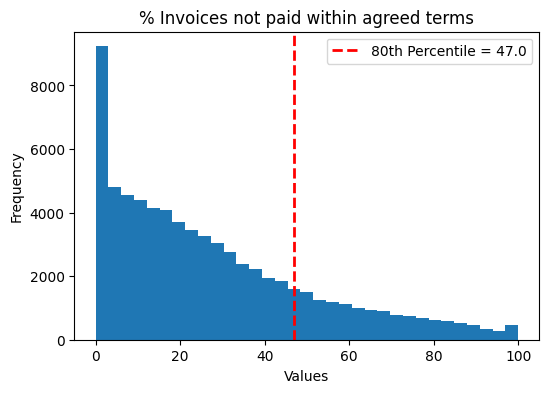

In [229]:
# Bar plot for '% Invoices not paid within agreed terms' and 80th percentile
percentile_80 = np.percentile(data['% Invoices not paid within agreed terms'].dropna(), 80)
print('80th Quantile = ',percentile_80)

plt.hist(data['% Invoices not paid within agreed terms'],bins=33)
plt.axvline(x=percentile_80, color='red', linestyle='dashed', linewidth=2, label='80th Percentile = '+str(percentile_80))

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('% Invoices not paid within agreed terms')

# Show the plot
plt.legend()
plt.show()

In [230]:
# Creating target column 'flag' based on the 80th percentile
data['flag'] = 0
data.loc[data['% Invoices not paid within agreed terms'] > percentile_80, 'flag'] = 1
data.drop(columns=['% Invoices not paid within agreed terms'],inplace=True)

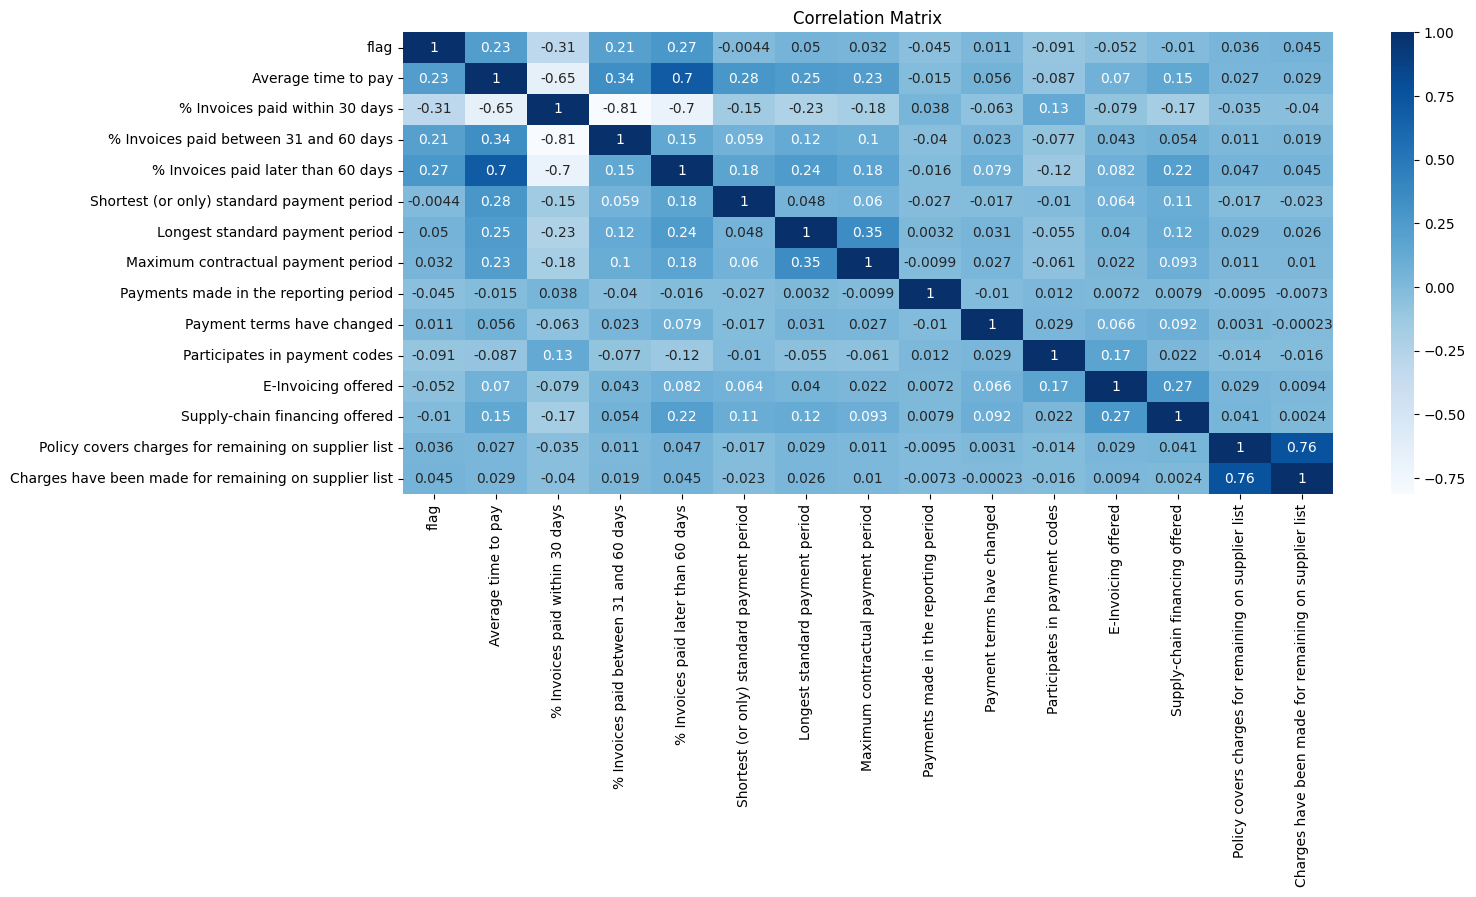

In [231]:
# Correlation Analysis
new_order=[     'flag',
                'Average time to pay',
                '% Invoices paid within 30 days',
                '% Invoices paid between 31 and 60 days',
                '% Invoices paid later than 60 days',
                'Shortest (or only) standard payment period',
                'Longest standard payment period', 'Maximum contractual payment period',
                'Payments made in the reporting period',
                'Payment terms have changed', 'Participates in payment codes',
                'E-Invoicing offered', 'Supply-chain financing offered',
                'Policy covers charges for remaining on supplier list',
                'Charges have been made for remaining on supplier list']
# Visualize the relationship between numerical columns using a correlation matrix
data = data.reindex(columns=new_order)
correlation_matrix = data.reindex(columns=new_order).corr()
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix,annot=True,cmap='Blues')
plt.title('Correlation Matrix')
plt.show()



In [232]:
correlation_threshold = 0.7
for feature, feature_values in correlation_matrix.items():
  for other_feature, correlation in feature_values.items():
    if feature != other_feature and abs(correlation) >= correlation_threshold:
      print(f"{feature} is highly correlated with {other_feature} (correlation: {correlation:.2f})")


% Invoices paid within 30 days is highly correlated with % Invoices paid between 31 and 60 days (correlation: -0.81)
% Invoices paid between 31 and 60 days is highly correlated with % Invoices paid within 30 days (correlation: -0.81)
Policy covers charges for remaining on supplier list is highly correlated with Charges have been made for remaining on supplier list (correlation: 0.76)
Charges have been made for remaining on supplier list is highly correlated with Policy covers charges for remaining on supplier list (correlation: 0.76)


In [233]:
# Dropping the Highly correlated Features
data = data.drop(columns=[ '% Invoices paid within 30 days', 
                            '% Invoices paid later than 60 days',
                            'Policy covers charges for remaining on supplier list',])

In [234]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['flag']), data['flag'], test_size=1/3, random_state=42)

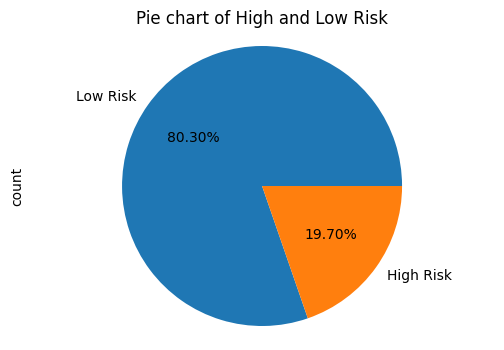

In [235]:
# Pie chart of High and Low Risk before Sampling
y_train.value_counts().plot.pie(autopct='%1.2f%%',labels=['Low Risk','High Risk'])
plt.axis('equal')
plt.title('Pie chart of High and Low Risk')
plt.show()

In [236]:
# Implemeting the RandomOverSampler
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='minority')
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

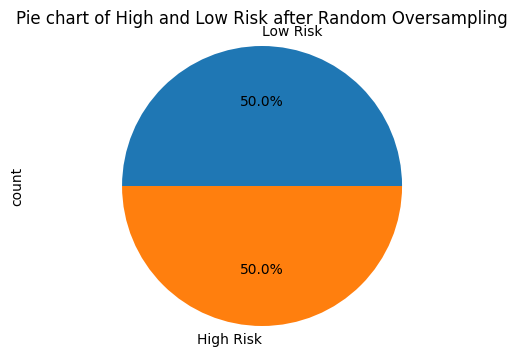

In [237]:
# pie chart of High and Low Risk after Random Oversampling
y_train_oversampled.value_counts().plot.pie(autopct='%1.1f%%',labels=['Low Risk','High Risk'])
plt.axis('equal')
plt.title('Pie chart of High and Low Risk after Random Oversampling')
plt.show()

In [238]:
# XGBoost Model
params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'min_child_weight': 1,
    'subsample': 0.85,
    'n_estimators': 900,
} 

xgb_clf = XGBRegressor(**params)

xgb_clf.fit(X_train_oversampled, y_train_oversampled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=900, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [239]:
y_pred = xgb_clf.predict(X_test)
y_pred1 = np.where(y_pred > 0.5, 1, 0)
# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred1)
print('XGBoost model accuracy score: ', accuracy)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred1)
print('F1 Score:', f1)

# Calculate ROC AUC Score
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('ROC AUC Score:', roc_auc)


XGBoost model accuracy score:  0.7801169095221958
F1 Score: 0.5582503616713471
ROC AUC Score: 0.8338378563596491


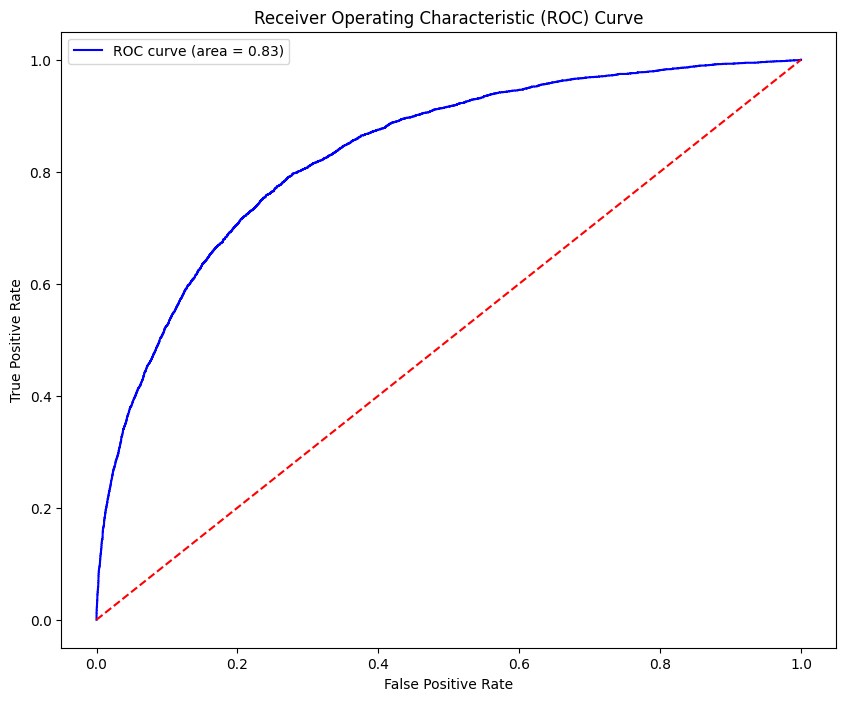

In [240]:
# Plot the ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [241]:
import joblib

# Save the model
joblib.dump(xgb_clf, 'model.pkl')


['model.pkl']

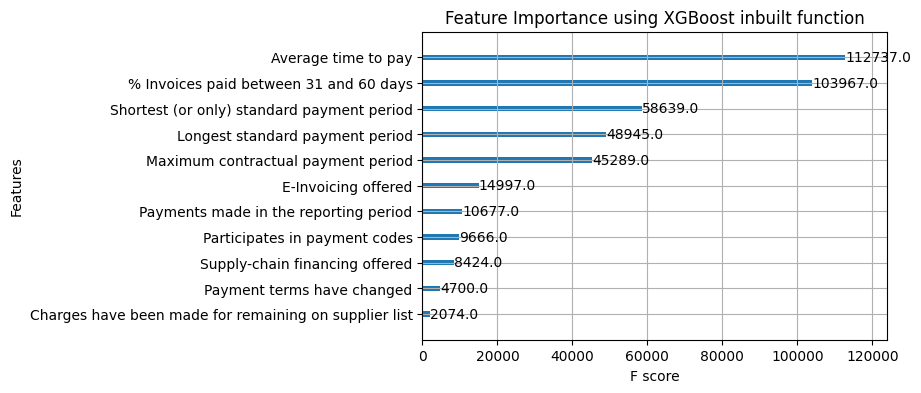

In [242]:
# Feature Importance using XGBoost inbuilt function
xgb.plot_importance(xgb_clf)
plt.rcParams['figure.figsize'] = [6, 4]
plt.title('Feature Importance using XGBoost inbuilt function') 
plt.show()

In [243]:
X_test.iloc[1000]

Average time to pay                                       55.0
% Invoices paid between 31 and 60 days                    57.0
Shortest (or only) standard payment period                 1.0
Longest standard payment period                           90.0
Maximum contractual payment period                        90.0
Payments made in the reporting period                        1
Payment terms have changed                               False
Participates in payment codes                            False
E-Invoicing offered                                      False
Supply-chain financing offered                           False
Charges have been made for remaining on supplier list    False
Name: 69062, dtype: object

In [244]:
y_pred[1000]

0.6350104

In [245]:
# Predict using the trained model
prediction = xgb_clf.predict([[55, 57, 1, 90, 90, True, False, False, False, False, False]])

# Print the prediction
print(prediction)


[0.6350104]


In [246]:
import joblib

# Load the saved model
loaded_model = joblib.load('model.pkl')

# Make predictions using the loaded model
prediction = loaded_model.predict([[1, 20, 70, 2, 80, 60, True, False, True, False, True]])

# Print the prediction
print(prediction)


[0.1760413]
